In this notebook we are trying to analyse the impact of large learning rates on generalization of model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST data
train_data = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### As per the figure 1-Right in the paper, this is an attempt to derive performace with increasing weight decays with a large learning rate (λ = 1.5)


Below is a simple LogisticRegression architecture to map an input image(28*28) to 10 classes for MNIST data set. 

In [2]:
# Define model architecture and hyperparameters
class LogisticRegression(nn.Module):
    def __init__(self, hidden_width):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.fc1(x)
        return x

Fixing value of learning rate as mentioned in paper to 1.5. 

Rest of the hyperparameters used are an assumption

In [3]:
lr = 1.5
weight_decays = [0,0.000001,0.00001,0.0001,0.001,0.01,0.1]
momentum = 0.9

###Because there is not a provision in pytorch to handle negative weight decay, calculating negative and positive weight decay separately 

##For positive weight decay values 

In [4]:
test_accuracy_values_varying_weight_decay = []
train_accuracy_values_varying_weight_decay = []

for weight_decay in weight_decays:
    model = LogisticRegression(100).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    test_accuracy_values = []
    train_accuracy_values = []
    for epoch in range(10):
        model.train()
        loss_values = []
        correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)

            loss.backward()
            optimizer.step()
            loss_values.append(loss.item())

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        train_accuracy = 100 * correct / total
        train_accuracy_values.append(train_accuracy)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        test_accuracy = 100 * correct / total
        test_accuracy_values.append(test_accuracy)
    test_accuracy_values_varying_weight_decay.append(test_accuracy_values)
    train_accuracy_values_varying_weight_decay.append(train_accuracy_values)

print("Test Accuracy Values: ", test_accuracy_values_varying_weight_decay)
print("Train Accuracy Values: ", train_accuracy_values_varying_weight_decay)

Test Accuracy Values:  [[86.15, 87.31, 89.18, 87.9, 89.43, 89.41, 90.14, 89.98, 86.86, 87.63], [87.18, 83.77, 88.56, 89.5, 87.54, 88.86, 87.99, 87.81, 88.47, 90.07], [88.49, 88.46, 82.74, 87.52, 87.17, 88.0, 88.02, 87.02, 83.87, 84.82], [83.36, 84.94, 85.26, 82.04, 82.77, 84.88, 85.62, 82.1, 83.8, 82.86], [77.45, 80.52, 70.31, 73.45, 70.52, 78.63, 83.0, 73.97, 75.84, 72.61], [63.89, 48.78, 41.56, 59.35, 52.51, 52.96, 49.42, 59.28, 62.57, 53.39], [31.26, 25.63, 27.1, 28.79, 9.74, 20.38, 10.44, 22.59, 28.25, 30.51]]
Train Accuracy Values:  [[85.13333333333334, 87.275, 87.78333333333333, 87.82166666666667, 88.16166666666666, 88.44333333333333, 88.425, 88.50833333333334, 88.395, 88.52166666666666], [84.77333333333333, 87.39, 87.645, 87.87666666666667, 88.11, 88.005, 88.15, 88.33666666666667, 88.41166666666666, 88.50666666666666], [84.73, 86.65, 86.74333333333334, 86.99833333333333, 86.93333333333334, 87.10833333333333, 87.13166666666666, 87.15166666666667, 87.17, 86.99666666666667], [82.46

##For negative weight decay values

In [6]:
test_accuracy_values_varying_negative_weight_decay = []
train_accuracy_values_varying_negative_weight_decay = []

for weight_decay in weight_decays:
    model = LogisticRegression(100).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    loss_fn = nn.CrossEntropyLoss()

    test_accuracy_values = []
    train_accuracy_values = []
    for epoch in range(10):
        model.train()
        loss_values = []
        correct = 0
        total = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)

            # Add weight decay penalty term to the loss
            l2_reg = torch.tensor(0.).to(device)
            for param in model.parameters():
                l2_reg += torch.norm(param, p=2)**2

            if weight_decay!=0:
              loss += weight_decay * l2_reg * (-1)

            loss.backward()
            optimizer.step()
            loss_values.append(loss.item())

            # calculate train accuracy
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        train_accuracy = 100 * correct / total
        train_accuracy_values.append(train_accuracy)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        test_accuracy = 100 * correct / total
        test_accuracy_values.append(test_accuracy)
    test_accuracy_values_varying_negative_weight_decay.append(test_accuracy_values)
    train_accuracy_values_varying_negative_weight_decay.append(train_accuracy_values)

print("Test Accuracy Values: ", test_accuracy_values_varying_negative_weight_decay)
print("Train Accuracy Values: ", train_accuracy_values_varying_negative_weight_decay)

Test Accuracy Values:  [[87.21, 89.17, 87.93, 89.38, 86.37, 89.23, 85.1, 88.91, 88.45, 89.85], [86.35, 89.21, 87.44, 87.84, 89.75, 88.8, 88.99, 88.72, 89.89, 89.52], [84.76, 89.1, 89.14, 90.87, 91.37, 90.93, 91.1, 91.18, 91.34, 91.05], [91.46, 91.55, 91.55, 91.55, 91.55, 91.55, 91.55, 9.8, 9.8, 9.8], [9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8], [9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8], [9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8, 9.8]]
Train Accuracy Values:  [[85.02666666666667, 87.31666666666666, 87.74, 88.01333333333334, 88.17833333333333, 88.355, 88.34333333333333, 88.52833333333334, 88.55166666666666, 88.445], [85.115, 87.48833333333333, 88.00333333333333, 88.32833333333333, 88.60666666666667, 88.65833333333333, 88.88166666666666, 88.92833333333333, 89.1, 88.90833333333333], [85.70666666666666, 88.75166666666667, 90.13, 90.97333333333333, 91.38166666666666, 91.935, 92.18, 92.45, 92.55666666666667, 92.63], [88.96166666666667, 91.91833333333334, 91.95, 91.95, 91.95

In [10]:
test_accuracy_values_varying_negative_weight_decay = test_accuracy_values_varying_negative_weight_decay[::-1]
test_accuracy_values_varying_negative_weight_decay.pop()

max_test_accuracy_values_negative = [max(lst) for lst in test_accuracy_values_varying_negative_weight_decay]
max_test_accuracy_values_positive = [max(lst) for lst in test_accuracy_values_varying_weight_decay]

max_test_accuracy = max_test_accuracy_values_negative + max_test_accuracy_values_positive

In [11]:
weight_decays = [-0.1,-0.01,-0.001,-0.0001,-0.00001,-0.000001,0,0.000001,0.00001,0.0001,0.001,0.01,0.1]

In [12]:
print(max_test_accuracy)
print(weight_decays)

[9.8, 9.8, 9.8, 91.55, 91.37, 89.89, 90.14, 90.07, 88.49, 85.62, 83.0, 63.89, 31.26]
[-0.1, -0.01, -0.001, -0.0001, -1e-05, -1e-06, 0, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]


##Plotting accuracy to weight decays

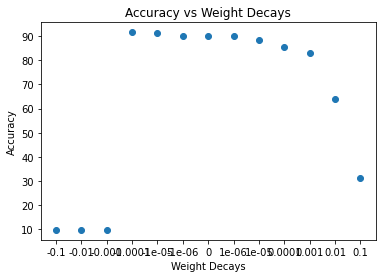

In [17]:
import numpy as np
import matplotlib.pyplot as plt

Accuracy = max_test_accuracy
Weight_decays = weight_decays

x = np.linspace(0, len(Weight_decays)-1, len(Weight_decays))
plt.scatter(x, Accuracy, marker='o')
plt.xlabel('Weight Decays')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Weight Decays')
plt.xticks(x, Weight_decays)
plt.show()

##Result

According to Figure-1-Right in the paper, it is possible to prove that a large learning rate can aid generalization by introducing an implicit regularization. As weight decay increases toward zero, the accuracy of the model increases, indicating that the model is generalizing well. However, if weight decay is increased beyond zero, the accuracy of the model drops, which implies that the model is over-regularized. This suggests that a large learning rate can help to prevent over-regularization by implicitly regularizing the model.

Note: Accuracy level is not comparable to one in paper for extremely low negative weight decays, weight amplification (i.e. using negative weight decay) is leading to overfitting 